<a href="https://colab.research.google.com/github/wangyu16/PolymerScienceEducation/blob/master/OVESET/09_Star_Branched_Polymers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a href="https://wangyu16.github.io/PolymerScienceEducation/"><img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/master/Fig/Logo_black.svg" width='150' /></a></center>

# Star and Branched Polymers

-----------

To learn the background knowledge, please visit this [study guide](https://hackmd.io/@YW2025/SyiT4N3A0)

## What does this simulator do and how to use it?

If the polymers have the same degree of polymerization but different molecular architecture, how would their "size" differ from one another. This simulator helps you to find out the answer.

To simplify the question, the simulation involve only two types of monomers. One type is bifunctional monomers that each can form linkage to another two monomers; another type is trifunctional monomers that each can link to another three monomers. In case of star polymer, the trifunctional monomers are consumed first, then the bifuncitonal monomers start to react. In case of branch polymer, both types of monomers are reacting randomly at the same time.  

Choose the degree of polymerization of the targeting polymer and the number of branching points, i.e., the number of trifunctional monomer units, and run all cells. The results show the sample polymers and compare the radii of gyration of three types of polymers, i.e., linear, star and branching.

In [1]:
#@title 1. Install and import packages {display-mode: "form" }
%%capture
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import concurrent.futures
!pip install sigfig
from sigfig import round
import random
import networkx as nx
from scipy.spatial.transform import Rotation as R
from IPython.display import clear_output

In [2]:
#@title 2. Simulation conditions. {display-mode: "form"}
#@markdown Please select the conditions you want to simulate.

DP = 400 #@param {type:"slider", min:100, max:2000, step:10}
nBranchPoint = 200 #@param {type:"slider", min:1, max:200, step:1}

nArms = nBranchPoint + 2
nStrands = 1 + 2*nBranchPoint

if DP < nBranchPoint:
  print("The number of branch point cannot be greater than DP.")


In [3]:
# @title  {"display-mode":"form"}
def plot_graph(G):
  """

  Args:
    G:
  """
  # Draw a cubic box surrounding the polymer
  pos = nx.get_node_attributes(G, 'pos')
  coordinates = np.array([pos[node] for node in G.nodes()])
  mass_center = np.mean(coordinates, axis=0)
  distances = np.linalg.norm(coordinates - mass_center, axis=1)
  farthestDistance = np.max(distances)
  half_side = farthestDistance/np.sqrt(3)*1.5
  # Create the cube vertices
  cube_vertices = np.array([
  mass_center + [-half_side, -half_side, -half_side],
  mass_center + [-half_side, -half_side, half_side],
  mass_center + [-half_side, half_side, -half_side],
  mass_center + [-half_side, half_side, half_side],
  mass_center + [half_side, -half_side, -half_side],
  mass_center + [half_side, -half_side, half_side],
  mass_center + [half_side, half_side, -half_side],
  mass_center + [half_side, half_side, half_side],
  ])

  # Define the edges of the cube
  edges = [
      (0, 1), (1, 3), (3, 2), (2, 0),
      (4, 5), (5, 7), (7, 6), (6, 4),
      (0, 4), (1, 5), (2, 6), (3, 7)
  ]

  # Create a Plotly figure
  fig = go.Figure()

  # Add the cube edges as line segments
  for edge in edges:
      point1 = cube_vertices[edge[0]]
      point2 = cube_vertices[edge[1]]
      fig.add_trace(go.Scatter3d(
          x=[point1[0], point2[0]],
          y=[point1[1], point2[1]],
          z=[point1[2], point2[2]],
          mode='lines',
          showlegend=False,
          line=dict(color='blue', width=1)
      ))

  # Extract node coordinates
  x_nodes = [pos[node][0] for node in G.nodes()]
  y_nodes = [pos[node][1] for node in G.nodes()]
  z_nodes = [pos[node][2] for node in G.nodes()]

  # Extract edge coordinates
  x_edges = []
  y_edges = []
  z_edges = []
  for edge in G.edges():
      x_edges += [pos[edge[0]][0], pos[edge[1]][0], None]
      y_edges += [pos[edge[0]][1], pos[edge[1]][1], None]
      z_edges += [pos[edge[0]][2], pos[edge[1]][2], None]

  # Add nodes
  fig.add_trace(go.Scatter3d(x=x_nodes, y=y_nodes, z=z_nodes, mode='markers', marker=dict(size=2)))

  # Add edges
  fig.add_trace(go.Scatter3d(x=x_edges, y=y_edges, z=z_edges, mode='lines', line=dict(width=1)))

  # Update layout for better visualization
  fig.update_layout(width=800, height=800, scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'), showlegend=False)

  # Display the plot
  fig.show()

def radius_of_gyration(G):
  """

  Args:
    G:

  Returns:

  """
  # Calculate the radius of gyration
  positions = np.array([pos for pos in nx.get_node_attributes(G, 'pos').values()])
  centerOfMass = np.mean(positions, axis=0)
  squaredDistances = np.sum((positions - centerOfMass)**2, axis=1)
  Rg = np.sqrt(np.mean(squaredDistances))
  return Rg

def n_of_branch(G):
  """

  Args:
    G:

  Returns:

  """
  count = 0
  for node in G.nodes():
    if G.degree(node) == 3:
      count += 1
  return count

def create_linear_polymer(DP):
  """

  Args:
    DP:

  Returns:

  """
  linearPolymer = nx.Graph()
  linearPolymer.add_node(0, pos=np.array([0, 0, 0]), type="Linear", functionality=2)
  for i in range(DP-1):
    position = linearPolymer.nodes[i]['pos']
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2 * np.pi)
    new_position = position + np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    linearPolymer.nodes[i]['functionality'] -= 1
    linearPolymer.add_node(i+1, pos=new_position, type="Linear", functionality=1)
    linearPolymer.add_edge(i, i+1)
  return linearPolymer

def create_star_polymer(nBranchPoint, DP):
  """

  Args:
    nBranchPoint:
    DP:

  Returns:

  """
  starPolymer = nx.Graph()
  starPolymer.add_node(f'Branch{0}', pos=np.array([0, 0, 0]), type="Branch", functionality=3)
  for i in range(nBranchPoint-1):
    functional_nodes = [node for node in starPolymer.nodes() if starPolymer.nodes[node].get('functionality', 0) != 0]
    idx = random.choice(functional_nodes)
    position = starPolymer.nodes[idx]['pos']
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2 * np.pi)
    new_position = position + np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    starPolymer.nodes[idx]['functionality'] -= 1
    starPolymer.add_node(f'Branch{i+1}', pos=new_position, type="Branch", functionality=2)
    starPolymer.add_edge(idx, f'Branch{i+1}')

  for i in range(DP-nBranchPoint):
    functional_nodes= [node for node in starPolymer.nodes() if starPolymer.nodes[node].get('functionality', 0) != 0]
    idx = random.choice(functional_nodes)
    position = starPolymer.nodes[idx]['pos']
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2 * np.pi)
    new_position = position + np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    starPolymer.nodes[idx]['functionality'] -= 1
    starPolymer.add_node(f'Linear{i}', pos=new_position, type="Linear", functionality=1)
    starPolymer.add_edge(idx, f'Linear{i}')

  return starPolymer

def create_branch_polymer(nBranchPoint, DP):
  """

  Args:
    nBranchPoint:
    DP:
  """
  branchPolymer = nx.Graph()
  branchPolymer.add_node(f'Branch{0}', pos=np.array([0, 0, 0]), type="Branch", functionality=3)
  nLinear = DP - nBranchPoint
  nBranch =  nBranchPoint -1
  # Add nodes with types
  i=1
  j=0
  while nBranch + nLinear:
    functional_nodes = [node for node in branchPolymer.nodes() if branchPolymer.nodes[node].get('functionality', 0) != 0]
    idx = random.choice(functional_nodes)
    position = branchPolymer.nodes[idx]['pos']
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2 * np.pi)
    new_position = position + np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    branchPolymer.nodes[idx]['functionality'] -= 1
    if random.randint(0, 2*nLinear+3*nBranch) < 3*nBranch:
      branchPolymer.add_node(f'Branch{i}', pos=new_position, type="Branch", functionality=2)
      branchPolymer.add_edge(idx, f'Branch{i}')
      nBranch -= 1
      i+=1
    else:
      branchPolymer.add_node(f'Linear{j}', pos=new_position, type="Linear", functionality=1)
      branchPolymer.add_edge(idx, f'Linear{j}')
      nLinear -= 1
      j+=1

  return branchPolymer

## 3. Simulation

In [4]:
# @title A sample of linear polymer {display-mode: "form"}
# Create one linear polymer example
linearPolymer0 = create_linear_polymer(DP)

nBranch = n_of_branch(linearPolymer0)
print(f'The degree of polymerization is {linearPolymer0.number_of_nodes()}.')
print(f'There are {nBranch} branching points found in the polymer.')
Rg = radius_of_gyration(linearPolymer0)
print(f'The radius of gyration is {round(Rg, sigfigs=3)}')
plot_graph(linearPolymer0)

The degree of polymerization is 400.
There are 0 branching points found in the polymer.
The radius of gyration is 6.63


In [5]:
# @title A sample of star polymer {display-mode: "form"}
starPolymer0= create_star_polymer(nBranchPoint, DP)
nBranch = n_of_branch(starPolymer0)
print(f'The degree of polymerization is {starPolymer0.number_of_nodes()}.')
print(f'There are {nBranch} branching points found in the polymer.')
Rg = radius_of_gyration(starPolymer0)
print(f'The radius of gyration is {round(Rg, sigfigs=3)}')
plot_graph(starPolymer0)

The degree of polymerization is 400.
There are 141 branching points found in the polymer.
The radius of gyration is 2.57


In [6]:
# @title A sample of branch polymer {display-mode: "form"}
branchPolymer0 = create_branch_polymer(nBranchPoint, DP)
nBranch = n_of_branch(branchPolymer0)
print(f'The degree of polymerization is {branchPolymer0.number_of_nodes()}.')
print(f'There are {nBranch} branching points found in the polymer.')
Rg = radius_of_gyration(branchPolymer0)
print(f'The radius of gyration is {round(Rg, sigfigs=3)}')
plot_graph(branchPolymer0)

The degree of polymerization is 400.
There are 111 branching points found in the polymer.
The radius of gyration is 3.69


In [7]:
# @title {display-mode: "form"}
%%time
# Define a function to generate polymers and calculate Rg
def generate_and_calculate(polymer_type, nBranchPoint, DP):
  if polymer_type == 'linear':
    polymer = create_linear_polymer(DP)
  elif polymer_type == 'star':
    polymer = create_star_polymer(nBranchPoint, DP)
  elif polymer_type == 'branch':
    polymer = create_branch_polymer(nBranchPoint, DP)
  else:
    return None
  Rg = radius_of_gyration(polymer)
  print(Rg)
  return Rg

n_samples = 400

# Use concurrent computation
with concurrent.futures.ThreadPoolExecutor() as executor:
  linear_futures = [executor.submit(generate_and_calculate, 'linear', nBranchPoint, DP) for _ in range(n_samples)]
  star_futures = [executor.submit(generate_and_calculate, 'star', nBranchPoint, DP) for _ in range(n_samples)]
  branch_futures = [executor.submit(generate_and_calculate, 'branch', nBranchPoint, DP) for _ in range(n_samples)]

# Collect results
linear_Rg = np.array([future.result() for future in linear_futures])
star_Rg = np.array([future.result() for future in star_futures])
branch_Rg = np.array([future.result() for future in branch_futures])

clear_output()

CPU times: user 37.3 s, sys: 1.55 s, total: 38.9 s
Wall time: 46.5 s


Linear polymer Rg mean value: 7.89; standard deviation: 2.04
Star polymer Rg mean value: 2.57; standard deviation: 0.233
Branch polymer Rg mean value: 2.83; standard deviation: 0.308


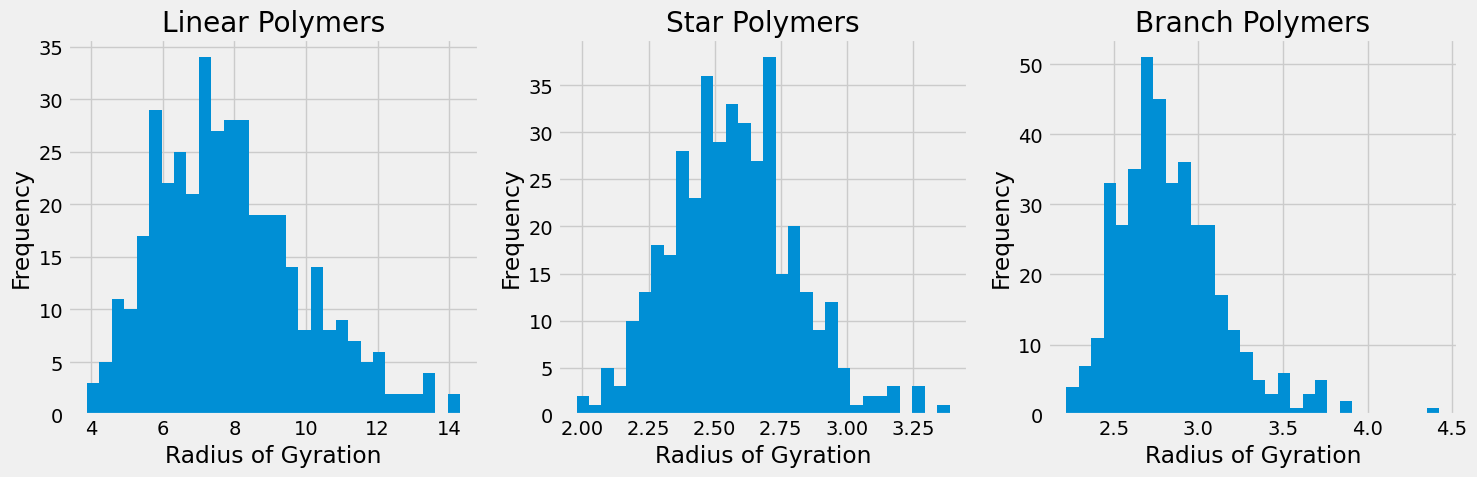

In [8]:
# @title 4. Results {display-mode: "form"}
#@markdown Statistical results of the radius of gyration

# Print or store the Rg values as needed
print(f"Linear polymer Rg mean value: {round(np.mean(linear_Rg), sigfigs=3)}; standard deviation: {round(np.std(linear_Rg), sigfigs=3)}")
print(f"Star polymer Rg mean value: {round(np.mean(star_Rg), sigfigs=3)}; standard deviation: {round(np.std(star_Rg), sigfigs=3)}")
print(f"Branch polymer Rg mean value: {round(np.mean(branch_Rg), sigfigs=3)}; standard deviation: {round(np.std(branch_Rg), sigfigs=3)}")

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms
axs[0].hist(linear_Rg, bins=30)
axs[0].set_title('Linear Polymers')
axs[0].set_xlabel('Radius of Gyration')
axs[0].set_ylabel('Frequency')

axs[1].hist(star_Rg, bins=30)
axs[1].set_title('Star Polymers')
axs[1].set_xlabel('Radius of Gyration')
axs[1].set_ylabel('Frequency')

axs[2].hist(branch_Rg, bins=30)
axs[2].set_title('Branch Polymers')
axs[2].set_xlabel('Radius of Gyration')
axs[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()



---



In [9]:
#@title Copyright { display-mode: "form" }
import requests
from IPython.display import Markdown
copyright = requests.get("https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/master/copyright.md")
Markdown(copyright.text)

### MIT License  

Copyright (c) 2021 -- 2024 Yu Wang

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Contact

Dr. Yu Wang  
Department of Chemistry  
Institute for Materials Research and Innovation  
University of Louisiana at Lafayette  
Lafayette, LA 70504  
Email: yuwang@louisiana.edu

### Acknowledgement

This project is sponsored by National Science Foundation (NSF-2142043). 


In [10]:
# @title {display-mode: "form" }
links = requests.get("https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/links.md")
Markdown(links.text)

---

### Links

**[Home page of OVESET](https://wangyu16.github.io/PolymerScienceEducation/):** 

<img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/img/QR_OVESET.svg" alt="OVESET Home Page" width="300">

**[Home page of Study Guide](https://hackmd.io/@YW2025/HJLiqoHRR)**

<img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/img/QR_PolymerStudyGuide.svg" alt="Introduction to Polymer Science" width="300">

